# Brain tumors classification using DenseNet Transfer Learning 

This tutorial presents an example of Transfer Learning with DenseNet model to classify images in tumor or healthy brain images.
It is interessant to perfom transfer-learning when you have not enough data to train a model.

You could use pretrained model with Fed-BioMed and classify your data and/or try to fine-tune the last layers of a pre-trained model with your specific data. This startegy could lead to better classifications results in you have enough data. 

Here is an example With a public dataset of MRI (Brain dataset from Kaggle).



## About the model

The model used is Densenet-121 model(“Densely Connected Convolutional Networks”) pretrained on ImageNet dataset. The Pytorch pretrained Densenet121 is used https://pytorch.org/vision/main/generated/torchvision.models.densenet121.html to perform image classification on the MedNIST dataset. The goal of this Densenet121 model is to predict the class of the image modality given the medical image.

## Librairies 

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
import pathlib
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.

import torch
import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import optim
import torch.optim as optim
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.



## Data 

Upload on a node the metadata.csv containing images and labels...

In [2]:
labels_df = pd.read_csv("/user/ebirgy/home/Downloads/Brain_Tumor_IRM/metadata.csv") # paths needs to be completed 
labels_df.drop(columns=['Unnamed: 0'], inplace=True)
print(labels_df.head().to_markdown())

|    | image           | class   | format   | mode   | shape         |
|---:|:----------------|:--------|:---------|:-------|:--------------|
|  0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


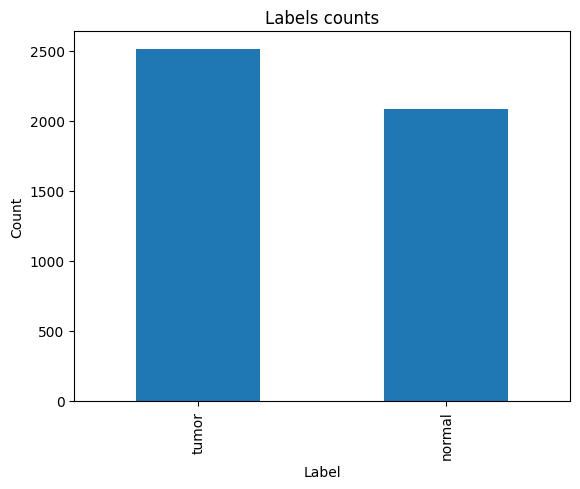

In [3]:
labels_df["class"].value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
# Encoding des categories : création d'un dictionnaire
label={'tumor': "1", 'normal': "0"}

In [ ]:
dict_label=dict(label)
labels_df["label"]=labels_df['class'].map(dict_label)

In [ ]:
# Specify the path where the images are located
path = "/user/ebirgy/home/Downloads/Brain_Tumor_IRM/"
# Add a new column 'full_path' to the DataFrame
labels_df['path_images'] = path + labels_df['image']


In [ ]:
labels_df.head()

In [ ]:
dataset=labels_df[['path_images', 'label', 'image']]
dataset['label']=dataset['label'].astype('int')

In [ ]:
dataset.head()

In [ ]:
dataset.to_csv("../cancer_labels.csv")
df = pd.read_csv("../cancer_labels.csv", index_col=0)

In [ ]:
df.iloc[0, 0]

In [ ]:
from fedbiomed.researcher.requests import Requests
req  = Requests()
req.list()

In [ ]:
from fedbiomed.common.training_plans import TorchTrainingPlan 
from fedbiomed.common.data import DataManager
from torch.utils.data import Dataset
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

## Use pre-trained model to classify your images data 

In [ ]:
class MyTrainingPlan2(TorchTrainingPlan):

    def init_model(self, model_args):
        # Define your custom classification layer
        class CustomClassifier(nn.Module):
            def __init__(self, in_features, num_classes):
                super(CustomClassifier, self).__init__()
                self.fc = nn.Linear(in_features, num_classes)
        
            def forward(self, x):
                x = self.fc(x)
                return x
        
        # Load the pre-trained DenseNet model
        model = models.densenet121(pretrained=True)
        
        # Modify the classifier layer
        in_features = model.classifier.in_features
        num_classes = model_args['num_classes']  # Change this to the number of classes in your dataset
        custom_classifier = CustomClassifier(in_features, num_classes)
        
        # Replace the classifier
        model.classifier = custom_classifier
        
        return model

    def init_dependencies(self):
        return [
            "import pandas as pd",
            "from PIL import Image",
            "from torchvision import datasets, transforms, models",
            "from torch.utils.data import Dataset",
            "import torch.optim as optim"
        ]


    def init_optimizer(self, optimizer_args):        
        return optim.Adam(self.model().parameters(), lr=optimizer_args["lr"])

    # training data
    class CustomDatasetFedBioMed(Dataset):
        def __init__(self, dataset_path: str, transform=None):
            self.dataframe = pd.read_csv(dataset_path, index_col=0)
            
            self.transform = transforms.Compose([
                transforms.Resize((224,224)),  
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(30),
                transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
           ])
    
        def __len__(self):
            return len(self.dataframe)
    
        def __getitem__(self, idx):
            
            img_path = self.dataframe.iloc[idx, 0]  # the file path is in the first column
            print(img_path)
            image = Image.open(img_path).convert("RGB")
    
            label = self.dataframe.iloc[idx, 1]  # the class label is in the second column
    
            if self.transform:
                image = self.transform(image)
    
            label = torch.tensor(label, dtype=torch.long)  # if it returns a tuple instead of a tensor
    
            return image, label 

    def training_data(self):
        dataset = self.CustomDatasetFedBioMed(self.dataset_path)
        return DataManager(dataset)

    def training_step(self, data, target):
        output = self.model().forward(data)
        loss_func = nn.CrossEntropyLoss()
        loss   = loss_func(output, target)
        return loss



In [ ]:
training_args = {
    'loader_args': { 'batch_size': 32, }, 
    'optimizer_args': {'lr': 1e-4}, 
    'epochs': 1, 
    'dry_run': False,  
    'batch_maxnum': 100 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

model_args = {
    'num_classes': 2
}

In [ ]:

tags =  ['cancer']
rounds = 1

exp = Experiment(tags=tags,
                 training_plan_class=MyTrainingPlan2,
                 model_args=model_args,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage())

from fedbiomed.common.metrics import MetricTypes
exp.set_test_ratio(.1)
exp.set_test_on_local_updates(True)
exp.set_test_metric(MetricTypes.ACCURACY)

exp.set_tensorboard(True)

In [ ]:
exp.run()

In [ ]:
exp.training_plan().export_model('./training_plan2_densenet')

## Fine-tune : train last layers before classification 

In [ ]:
class MyTrainingPlan3(TorchTrainingPlan):

    def init_model(self, model_args):
        model = models.densenet121(pretrained=True)
        # For example, let's freeze all layers up to the second-to-last dense block
        for param in model.features[:-6].parameters():
            param.requires_grad = False

        # Modify the classifier to match the number of classes in your dataset
        num_ftrs = model.classifier.in_features
        num_classes = model_args['num_classes'] 
        model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
            )
        
        return model

    def init_dependencies(self):
        return [
            "import pandas as pd",
            "from PIL import Image",
            "from torchvision import datasets, transforms, models",
            "from torch.utils.data import Dataset",
            "import torch.optim as optim"
        ]


    def init_optimizer(self, optimizer_args):        
        return optim.Adam(self.model().parameters(), lr=optimizer_args["lr"])

    # training data
    class CustomDatasetFedBioMed(Dataset):
        def __init__(self, dataset_path: str, transform=None):
            self.dataframe = pd.read_csv(dataset_path, index_col=0)
            
            self.transform = transforms.Compose([
                transforms.Resize((224,224)),  
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(30),
                transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
           ])
    
        def __len__(self):
            return len(self.dataframe)
    
        def __getitem__(self, idx):
            
            img_path = self.dataframe.iloc[idx, 0]  # the file path is in the first column
            print(img_path)
            image = Image.open(img_path).convert("RGB")
    
            label = self.dataframe.iloc[idx, 1]  # the class label is in the second column
    
            if self.transform:
                image = self.transform(image)
    
            label = torch.tensor(label, dtype=torch.long)  # if it returns a tuple instead of a tensor
    
            return image, label 

    def training_data(self):
        dataset = self.CustomDatasetFedBioMed(self.dataset_path)
        return DataManager(dataset)

    def training_step(self, data, target):
        output = self.model().forward(data)
        loss_func = nn.CrossEntropyLoss()
        loss   = loss_func(output, target)
        return loss




In [ ]:
training_args = {
    'loader_args': { 'batch_size': 32, }, 
    'optimizer_args': {'lr': 1e-4}, 
    'epochs': 1, 
    'dry_run': False,  
    'batch_maxnum': 100 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

model_args = {
    'num_classes': 2
}

In [ ]:
tags =  ['cancer']
rounds = 1


exp = Experiment(tags=tags,
                 training_plan_class=MyTrainingPlan3,
                 model_args=model_args,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage())


from fedbiomed.common.metrics import MetricTypes
exp.set_test_ratio(.1)
exp.set_test_on_local_updates(True)
exp.set_test_metric(MetricTypes.ACCURACY)

exp.set_tensorboard(True)

In [ ]:
from fedbiomed.researcher.environ import environ
tensorboard_dir = environ['TENSORBOARD_RESULTS_DIR']

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir "$tensorboard_dir"

In [ ]:
exp.run()

In [ ]:
exp.training_plan().export_model('./training_planxxxxx')